In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, sys
from os.path import isfile, join
import tensorflow as tf
from scipy import stats
import time
from imp import reload

%matplotlib inline

In [4]:
read_file_path = "/home/ch194765/repos/atlas-active-learning/"

sys.path.insert(0, read_file_path)
import prep_dat

import NN
import NNAL
import NNAL_tools

# Playing with TF Gradients

In [506]:
# input
X = tf.placeholder("float", [3, None])
y = tf.placeholder("float", [2, None])

# layer one
W_1 = tf.Variable(tf.ones([3,3]))
b_1 = tf.Variable(tf.zeros([3,1]))
z_1 = tf.add(tf.matmul(W_1, X), b_1)
a_1 = tf.nn.sigmoid(z_1)

# layer two (last layer)
W_2 = tf.Variable(tf.ones([2,3]))
b_2 = tf.Variable(tf.zeros([2,1]))
z_2 = tf.add(tf.matmul(W_2, a_1), b_2)
a_2 = tf.sigmoid(z_2)   # (output)

# loss function
J = tf.multiply(tf.reduce_sum(tf.pow(tf.subtract(y, a_2), 2)), .5)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [3]:
Xin = np.array([[1., 0.], [0., 1.], [0., 0.]])
yin = np.array([[1., 0.], [0., 1.]])
grad_vals = tf.gradients(J, [W_1, b_1, W_2, b_2])
sess.run(grad_vals, feed_dict={X:Xin, y:yin})

[array([[ 0.014189,  0.014189,  0.      ],
        [ 0.014189,  0.014189,  0.      ],
        [ 0.014189,  0.014189,  0.      ]], dtype=float32),
 array([[ 0.02837801],
        [ 0.02837801],
        [ 0.02837801]], dtype=float32),
 array([[ 0.05275872,  0.05275872,  0.05275872],
        [ 0.05275872,  0.05275872,  0.05275872]], dtype=float32),
 array([[ 0.07216756],
        [ 0.07216756]], dtype=float32)]

In [ ]:
optimizer = tf.train.GradientDescentOptimizer(56)
G = optimizer.compute_gradients(J, [W_1, b_1, W_2, b_2])
Gs = sess.run(G, feed_dict={X:Xin, y:yin})
#Gs

# Try Some Active Learning on an MNIST Example

## Single-Layer Fully-Connected Network

In [4]:
# load the data from TF 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Here, we don't use all the training data of the `mnist` object since we need to leave some part of the training unlabeled to do querying. Hence, we manually take a portion of the training as the initial labeled data set, and use the rest for evaluating our active learning method.

In [46]:
reload(prep_dat)
reload(NNAL_tools)
# number of the initial labeled data set
init_size = 200
batch_size = 50
epochs = 100

batch_of_data, batch_of_labels, pool_images, pool_labels, test_images, test_labels = \
    NNAL_tools.init_MNIST(init_size, batch_size)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [168]:
tf.reset_default_graph()

#batch_of_data = fi_data
#batch_of_labels = fi_labels

# input and output placeholders
c=10
x = tf.placeholder(tf.float32, shape=[784, None])
y_ = tf.placeholder(tf.float32, shape=[c, None])

# parameters
W = tf.Variable(tf.zeros([c, 784]))
b = tf.Variable(tf.zeros([c, 1]))

# output should be a normalized 
y = tf.matmul(W, x) + b
posterior = tf.nn.softmax(y)
#grads = NNAL_tools.enlist_gradients(log_posteriors, 2, [W,b])

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y_), logits=tf.transpose(y)))

# optimization iteration
train_step = tf.train.AdamOptimizer(0.05).minimize(cross_entropy)

# doing the optimization
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(epochs):
        for i in range(len(batch_of_data)-1):
              train_step.run(feed_dict={x: batch_of_data[i], 
                                        y_: batch_of_labels[i]})
                
    correct_prediction = tf.equal(tf.argmax(y,0), tf.argmax(y_,0))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Initial Accuracy: %.4f" % accuracy.eval(feed_dict={x: test_images, y_: test_labels}))
    Wvv = sess.run(W, feed_dict={x: batch_of_data[i], y_: batch_of_labels[i]})

Initial Accuracy: 0.7829


In [184]:
np.sum(Wvv - Wv.T, axis=1)

array([ 0.00124264,  0.00028693, -0.00054589, -0.00129022,  0.0003822 ,
        0.00032684, -0.00055501,  0.00011522,  0.00085843,  0.00059104], dtype=float32)

In [1059]:
posteriors = sess.run(posterior, feed_dict={x:pool_images, y_:pool_labels})

posteriors[posteriors==0] += 1e-8
ents = -np.sum(posteriors * np.log(posteriors), axis=0)
np.where(pool_labels[:,np.argsort(-ents)[:20]])

(array([0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 7, 7]),
 array([ 5,  7, 15, 19,  0,  1,  2,  3,  6,  8,  9, 10, 12, 14, 16, 17, 18,
        11,  4, 13]))

### Difficulty with Taking Gradients with TensorFlow

In [ ]:
# log-posteriors (or log-likelihood wrt the parameters)
log_posteriors = tf.log(tf.nn.softmax(y))

# compute the gradiants for all the tests
test_size = mnist.test.images.shape[0]
c = mnist.test.labels.shape[1]
gr_log_posteriors = np.zeros((test_size, c))
for i in range(test_size):
    for j in range(c):
        grads = tf.gradients(log_posteriors[0][j], [W, b])
        # we use [i:i+1,:] since if we only use [i,:] TF gets upset
        grW, grb = sess.run(grads, feed_dict={x: mnist.test.images[i:i+1,:], y_: mnist.test.labels[i:i+1,:]})
        gr_log_posteriors[i,j] = np.sum(grW**2) + np.sum(grb**2)
    
    #if i % 100 == 0: print(i)
    print(i)

Unfortunately, computing the gradients for all the unlabeled samples in the pool separately, in a way above cell shows, takes a long time. Instead of calling TensorFlow each time for computing a gradient (by calling `sess.run()`), we somehow try to collect all the gradients in a list, and then call TensorFlow ones. Note that, simply feeding all the posteriors in the form of `tf.Variable`, e.g., `log_posteriors` in this case, is not helpful because the function `tf.gradients` returns the summation of all the derivatives of the input tensors. If we need the gradients of each tensor separately, we should form a list of TensorFlow gradient-functions with all the functions to differentiate. Then, this list will be fed to the TensorFlow at once and in one call.

### Double-Checking the Derivatives

In [821]:
reload(NNAL_tools)
log_posteriors = tf.log(tf.nn.softmax(tf.transpose(y)))
grads = NNAL_tools.enlist_gradients(log_posteriors, 2, [W,b])
#sess.run(grads, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
A = sess.run(grads, feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]})

In [864]:
#A = sess.run(grads, feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]})

posteriors = sess.run(tf.nn.softmax(tf.transpose(y)), feed_dict={x: pool_images[:,:2], y_: pool_labels[:,:2]}).T
class_j = 5
sample = 0
wi=0
wj=151
print(A[sample*10+j][0][wi,wj])

cann_vec = np.zeros(10)
cann_vec[class_j] = 1.
grW_classj = np.outer(cann_vec-posteriors[:,sample], pool_images[:,sample])


grW_classj.shape,A[sample*10+j][0].shape
np.where(A[sample*10+j][0]>0)
#print(A[sample*10+j][0][5,271])
#print(grW_classj[5,271])

0.993665
0.993664902755


## Running Active Learning on Single-Layer Network on MNIST

In [1355]:
reload(NNAL)
reload(NNAL_tools)
start_time = time.time()
tf.reset_default_graph()

(fi_accs, fi_added_labels), (rand_accs, rand_added_labels), (ent_accs, ent_added_labels) = \
    NNAL.test_MNIST(100, None, 1, 200, 50, 50)
    
delta_time = (time.time() - start_time) / 60.
print("elapsed time: %f" % delta_time)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Doing FI-based querying
Initializing the model...
Starting the querying iterations..
Iteration 1 is done. Number of labels: 201
Iteration 2 is done. Number of labels: 202
Iteration 3 is done. Number of labels: 203
Iteration 4 is done. Number of labels: 204
Iteration 5 is done. Number of labels: 205
Iteration 6 is done. Number of labels: 206
Iteration 7 is done. Number of labels: 207
Iteration 8 is done. Number of labels: 208
Iteration 9 is done. Number of labels: 209
Iteration 10 is done. Number of labels: 210
Iteration 11 is done. Number of labels: 211
Iteration 12 is done. Number of labels: 212
Iteration 13 is done. Number of labels: 213
Iteration 14 is done. Number of labels: 214
Iteration 15 is done. Number of labels: 215
Iteration 16 is done. Number of labels: 216
Iteration 17 is done. Numb

Iteration 80 is done. Number of labels: 280
Iteration 81 is done. Number of labels: 281
Iteration 82 is done. Number of labels: 282
Iteration 83 is done. Number of labels: 283
Iteration 84 is done. Number of labels: 284
Iteration 85 is done. Number of labels: 285
Iteration 86 is done. Number of labels: 286
Iteration 87 is done. Number of labels: 287
Iteration 88 is done. Number of labels: 288
Iteration 89 is done. Number of labels: 289
Iteration 90 is done. Number of labels: 290
Iteration 91 is done. Number of labels: 291
Iteration 92 is done. Number of labels: 292
Iteration 93 is done. Number of labels: 293
Iteration 94 is done. Number of labels: 294
Iteration 95 is done. Number of labels: 295
Iteration 96 is done. Number of labels: 296
Iteration 97 is done. Number of labels: 297
Iteration 98 is done. Number of labels: 298
Iteration 99 is done. Number of labels: 299
Iteration 100 is done. Number of labels: 300
Doing uncertainty sampling
Initializing the model...
Starting the querying 

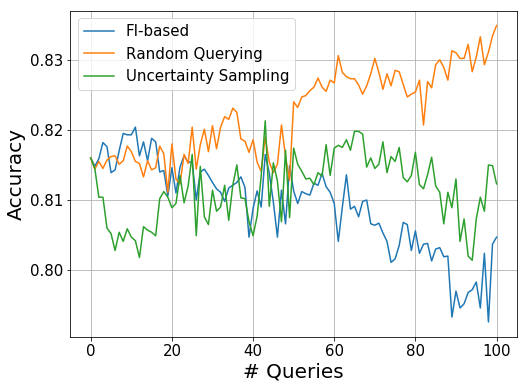

In [1356]:
plt.figure(figsize=(8,6))
plt.plot(fi_accs[0,:], label = 'FI-based')
plt.plot(rand_accs[0,:], label='Random Querying')
plt.plot(ent_accs[0,:], label='Uncertainty Sampling')
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('# Queries', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.grid()

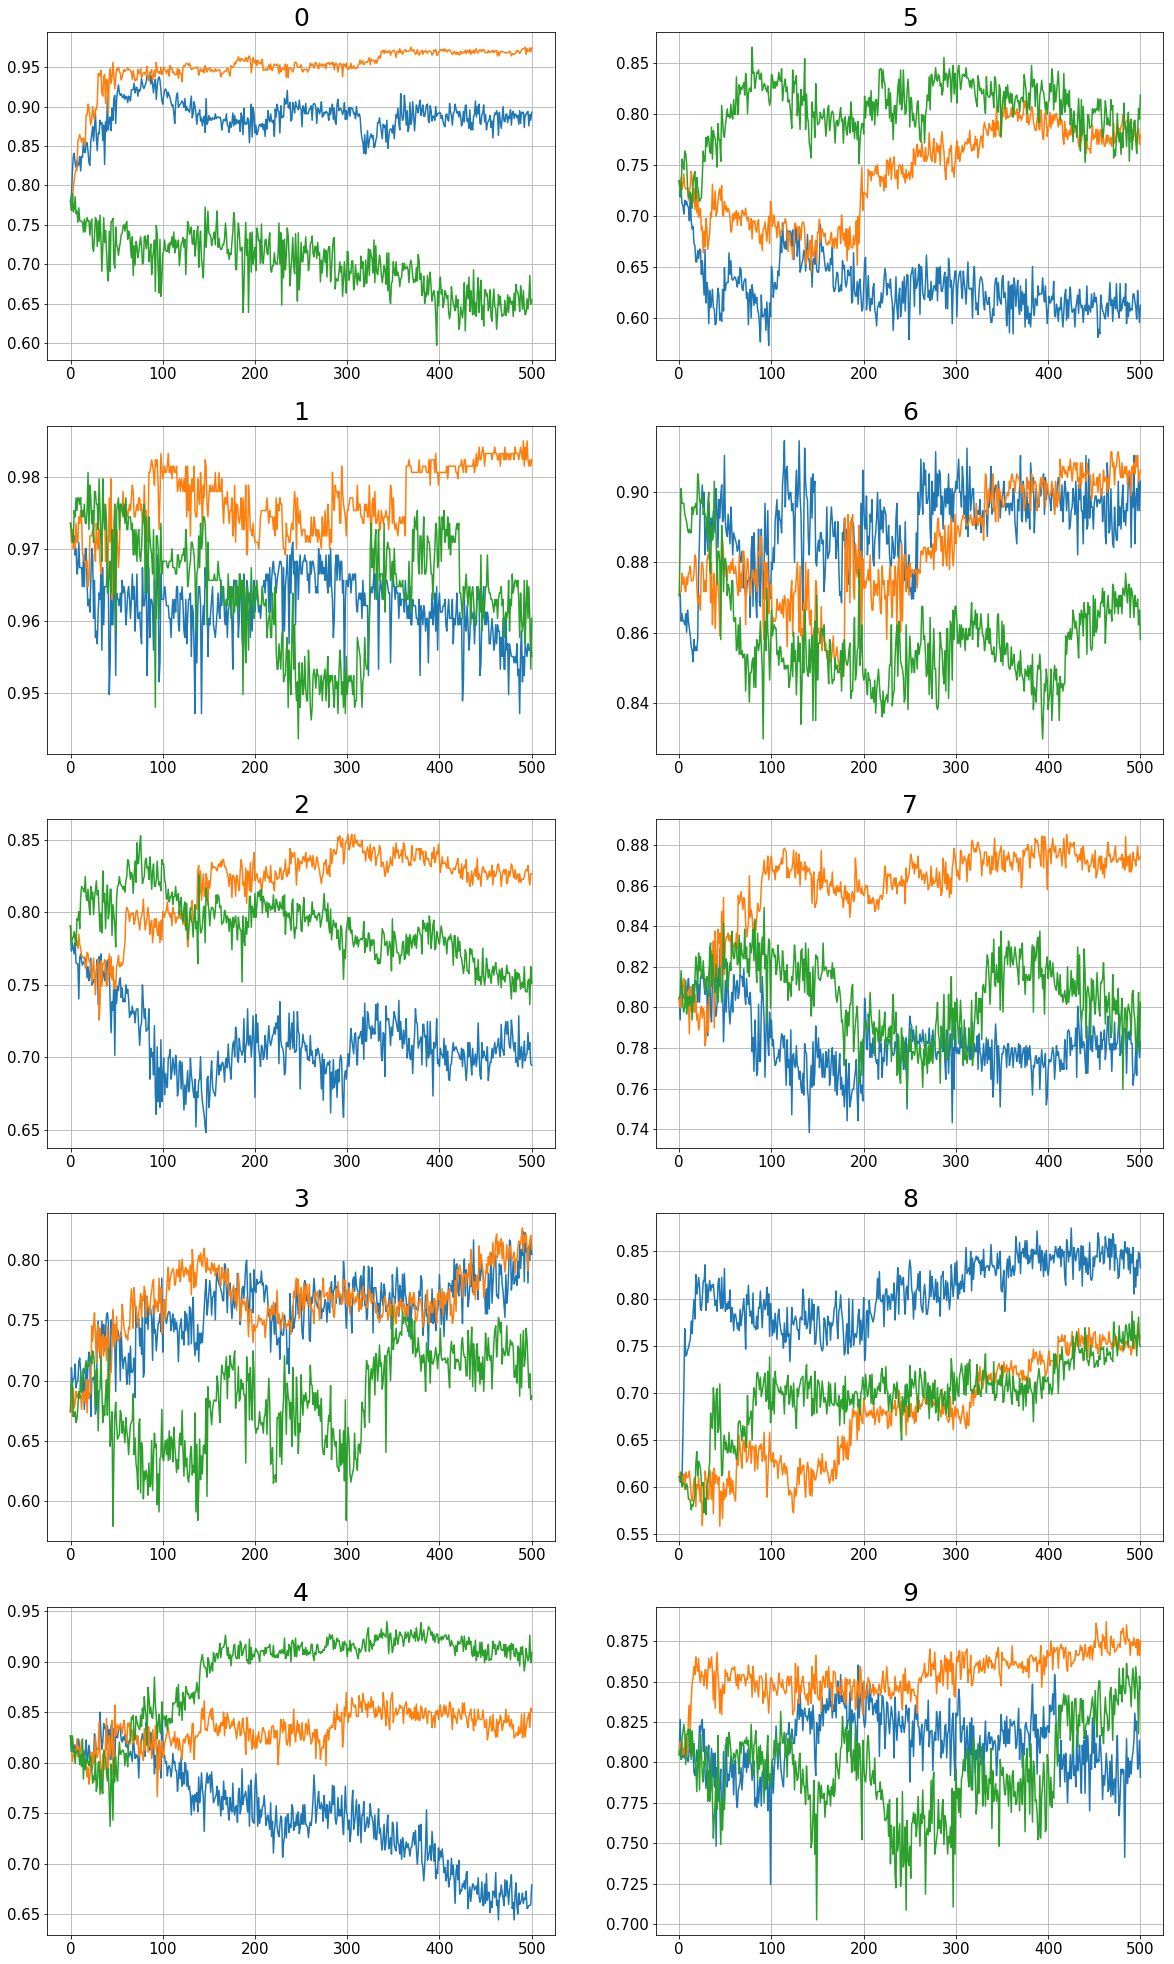

In [1352]:
fig,axes = plt.subplots(5,2, figsize=(20,35))
for i in range(0,10):
    axes[i%5, int(i/5)].plot(fi_accs[i+1,:], label='FI-based')
    axes[i%5, int(i/5)].plot(rand_accs[i+1,:], label='Random')
    axes[i%5, int(i/5)].plot(ent_accs[i+1,:], label='Uncertainty')
    axes[i%5, int(i/5)].set_title('%d'% i, fontsize=25)
    plt.sca(axes[i%5, int(i/5)])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    axes[i%5, int(i/5)].grid()

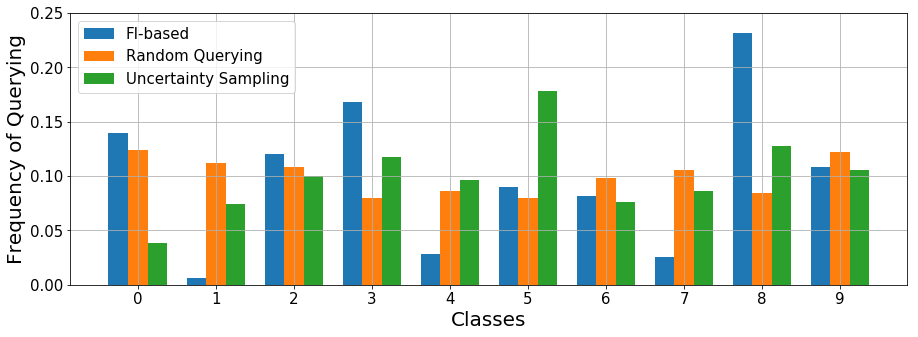

In [1329]:
fi_bins = np.histogram(fi_added_labels)[0]/500
rand_bins = np.histogram(rand_added_labels)[0]/500
ent_bins = np.histogram(ent_added_labels)[0]/500

plt.figure(figsize=(15,5))
plt.bar(np.arange(10)-.25,fi_bins, width=.25, label='FI-based')
plt.bar(np.arange(10),rand_bins, width=.25, label='Random Querying')
plt.bar(np.arange(10)+.25,ent_bins, width=.25, label='Uncertainty Sampling')
plt.xticks(np.arange(10), fontsize=15)
plt.yticks([0.,.05,.1,.15,.2,.25], fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("Classes", fontsize=20)
plt.ylabel("Frequency of Querying", fontsize=20)
plt.grid()

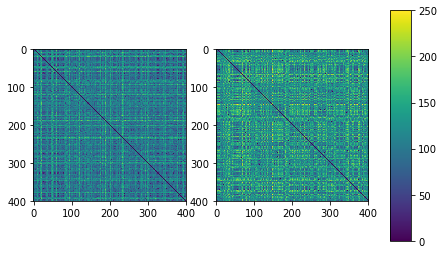

In [918]:
iters = 400
dist_map_rand = np.zeros((iters,iters))
dist_map_fi = np.zeros((iters,iters))

fi_condat = np.concatenate(fi_data, axis=1)
rand_condat = np.concatenate(rand_data, axis=1)

for i in range(iters):
    for j in range(iters):
        dist_map_rand[i,j] = np.sum((rand_condat[:,i] - rand_condat[:,j])**2)
        dist_map_fi[i,j] = np.sum((fi_condat[:,i] - fi_condat[:,j])**2)

fig, axes = plt.subplots(nrows=1, ncols=2)
im = axes[0].imshow(dist_map_rand, vmin=0, vmax=250)
im = axes[1].imshow(dist_map_fi, vmin=0, vmax=250)

cax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
fig.colorbar(im,cax)

<Container object of 10 artists>

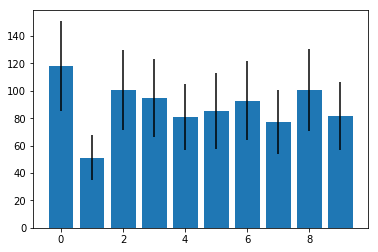

In [1169]:
norms_mean = np.zeros(10)
norms_std = np.zeros(10)
for i in range(10):
    class_indics = mnist.train.labels[:,i]==1.
    norms_mean[i] = np.mean(np.sum(mnist.train.images[class_indics,:]**2,axis=1))
    norms_std[i] = np.std(np.sum(mnist.train.images[class_indics,:]**2,axis=1))

plt.bar(np.arange(10), norms_mean, yerr = norms_std)

In [ ]:
reload(NNAL)
ent_accs, ent_data, ent_labels, added_images = \
    NNAL.querying_iterations_MNIST(batch_of_data, batch_of_labels, 
                                   pool_images, pool_labels, 
                                   test_images, test_labels,
                                   50, 1, 50, method="entropy")

fig,axes = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    axes[int(i/5), i%5].imshow(np.reshape(added_images[i,:],(28,28)), cmap='gray')
    axes[int(i/5), i%5].axis('off')

In [ ]:
reload(NNAL)
rand_raccs, _, _, rand_added_images = \
    NNAL.querying_iterations_MNIST(batch_of_data, batch_of_labels, 
                                   pool_images, pool_labels, 
                                   test_images, test_labels,
                                   50, 1, 50, method="random")

fig,axes = plt.subplots(10,5, figsize=(10,25))
for i in range(50):
    axes[int(i/5), i%5].imshow(np.reshape(rand_added_images[i,:],(28,28)), cmap='gray')
    axes[int(i/5), i%5].axis('off')

In [1357]:
reload(NNAL)
fi_accs, _, _, fi_added_images = \
    NNAL.querying_iterations_MNIST(batch_of_data, batch_of_labels, 
                                   pool_images, pool_labels, 
                                   test_images, test_labels,
                                   50, 1, 50, method="FI")
    

Initializing the model...
Starting the querying iterations..
Iteration 1 is done. Number of labels: 201
Iteration 2 is done. Number of labels: 202
Iteration 3 is done. Number of labels: 203
Iteration 4 is done. Number of labels: 204
Iteration 5 is done. Number of labels: 205
Iteration 6 is done. Number of labels: 206
Iteration 7 is done. Number of labels: 207
Iteration 8 is done. Number of labels: 208
Iteration 9 is done. Number of labels: 209
Iteration 10 is done. Number of labels: 210
Iteration 11 is done. Number of labels: 211
Iteration 12 is done. Number of labels: 212
Iteration 13 is done. Number of labels: 213
Iteration 14 is done. Number of labels: 214
Iteration 15 is done. Number of labels: 215
Iteration 16 is done. Number of labels: 216
Iteration 17 is done. Number of labels: 217
Iteration 18 is done. Number of labels: 218
Iteration 19 is done. Number of labels: 219
Iteration 20 is done. Number of labels: 220
Iteration 21 is done. Number of labels: 221
Iteration 22 is done. Nu

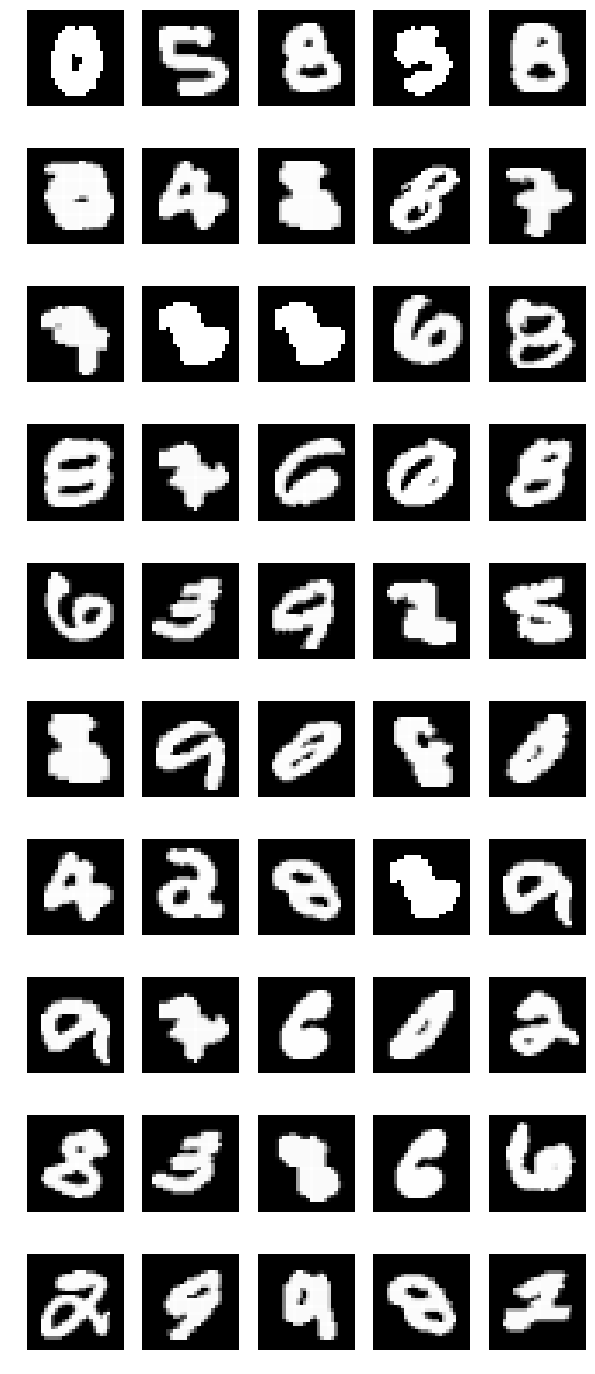

In [1358]:
fig,axes = plt.subplots(10,5, figsize=(10,25))
for i in range(50):
    axes[int(i/5), i%5].imshow(np.reshape(fi_added_images[i,:],(28,28)), cmap='gray')
    axes[int(i/5), i%5].axis('off')

## Convolutional Networks

In [1390]:
reload(NN)
W_dict, b_dict = NN.CNN_variables([5,5], [1, 32, 64])

In [1398]:
W = W_dict['0']
b = b_dict['0']
CNN_output = NN.CNN_layers(W_dict, b_dict, x)
CNN_output = tf.reshape(CNN_output, [7*7*64, -1])
w_fc1 = NN.weight_variable([1024, 7*7*64])
tf.matmul(w_fc1, CNN_output)
NN.bias_variable([1024])

<tf.Variable 'Variable_32:0' shape=(1024,) dtype=float32_ref>

In [301]:
reload(NN)
NN.train_CNN_MNIST()


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.06
step 100, training accuracy 0.82
step 200, training accuracy 0.96
step 300, training accuracy 0.9
step 400, training accuracy 0.96
step 500, training accuracy 0.94
step 600, training accuracy 0.96
step 700, training accuracy 0.96
step 800, training accuracy 0.94
step 900, training accuracy 0.96
step 1000, training accuracy 0.94
step 1100, training accuracy 0.98
step 1200, training accuracy 0.9
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.96
step 1700, training accuracy 0.98
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 0.96
step 2200, training accuracy 1
step 2300, training accuracy 0.98
step 2400, tr

In [7]:
batch = mnist.train.next_batch(50)

In [295]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    #initial = tf.constant(.1, shape=shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


#W_conv1 = weight_variable([5, 5, 1, 32])
#b_conv1 = bias_variable([32])
#x_image = tf.reshape(x, [-1, 28, 28, 1])
#h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#h_pool1 = max_pool_2x2(h_conv1)
#h_pool1_flat = tf.reshape(h_pool1, [-1, 14*14*32])


W_fc1 = weight_variable([784, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gr = tf.gradients(cross_entropy, [W_fc2])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})

    
    
    b = sess.run(b_fc2, feed_dict={x: mnist.test.images[:1,:], y_: mnist.test.labels[:1,:]})
    #H = sess.run(h_fc1, feed_dict={x: mnist.test.images[:1,:], y_: mnist.test.labels[:1,:]})
    W = sess.run(W_fc2, feed_dict={x: mnist.test.images[:1,:], y_: mnist.test.labels[:1,:]})
    Y = sess.run(y_conv, 
                 feed_dict={x: mnist.test.images[:1,:], y_: mnist.test.labels[:1,:]})
    grW = sess.run(gr, feed_dict={x: mnist.test.images[:1,:], y_: mnist.test.labels[:1,:]})

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.1
step 100, training accuracy 0.82
step 200, training accuracy 0.9
step 300, training accuracy 0.94
step 400, training accuracy 0.86
step 500, training accuracy 0.94
step 600, training accuracy 0.96
step 700, training accuracy 0.94
step 800, training accuracy 0.9
step 900, training accuracy 0.98


In [297]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    #initial = tf.constant(.1, shape=shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

x = tf.placeholder(tf.float32, shape=[784, None])
y_ = tf.placeholder(tf.float32, shape=[10, None])


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(tf.transpose(x), [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_pool1_flat = tf.reshape(tf.transpose(h_pool1), [14*14*32, -1])


W_fc1 = weight_variable([1024, 14*14*32])
b_fc1 = bias_variable([1024,1])
h_fc1 = tf.nn.relu(tf.matmul(W_fc1, h_pool1_flat) + b_fc1)

W_fc2 = weight_variable([10,1024])
b_fc2 = bias_variable([10,1])

y_conv = tf.matmul(W_fc2, h_fc1) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y_), logits=tf.transpose(y_conv)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 0), tf.argmax(y_, 0))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

gr = tf.gradients(cross_entropy, [W_fc2])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0].T, y_: batch[1].T})
    
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0].T, y_: batch[1].T})

        
    W2 = sess.run(W_fc2, feed_dict={x: mnist.test.images[:1,:].T, y_: mnist.test.labels[:1,:].T})
    b2 = sess.run(b_fc2, feed_dict={x: mnist.test.images[:1,:].T, y_: mnist.test.labels[:1,:].T})
    Y1 = sess.run(y_conv, 
                 feed_dict={x: mnist.test.images[:1,:].T, y_: mnist.test.labels[:1,:].T})
    
    im = sess.run(x_image, feed_dict={x: mnist.test.images[:2,:].T, y_: mnist.test.labels[:2,:].T})

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.04
step 100, training accuracy 0.9
step 200, training accuracy 0.88
step 300, training accuracy 0.92
step 400, training accuracy 0.98
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 1
step 800, training accuracy 0.96
step 900, training accuracy 1


In [250]:
Y.shape, Y1.shape

print(np.unique(H1))
print(np.unique(H))
print(Y) 
print(Y1.T)

[ 0.13711226]
[ 0.]
[[ 0.21129932  0.13623525  0.03299285  0.36853471  0.18322821 -0.12532364
   0.18185532  0.19416384  0.4458884   0.09676092]]
[[ 0.364472    0.24926832 -0.04438945  0.48004746  0.11035258  0.06423579
  -0.0941101   0.40855172  0.16012397  0.10577615]]


In [287]:
b[:10], b2[:10].T
batch[0][0,320:330]

array([ 0.        ,  0.24705884,  0.1254902 ,  0.        ,  0.        ,
        0.        ,  0.45490199,  0.99215692,  0.85490203,  0.07450981], dtype=float32)

In [263]:
np.sum(np.abs(grW[0].T-grW1[0])>.001, axis=1)
#grW[0].shape, grW1[0].shape
#grW[0], grW1[0].T
W, W2.T
np.sum(W-W2.T, axis=0)

array([   32.35204697, -1177.12780762,  1122.5534668 ,  1169.16687012,
       -1199.05004883,   866.98181152,  1206.76000977, -1013.12103271,
       -1047.88745117, -1282.78979492], dtype=float32)

In [303]:
np.sum(H1.T==H)
H, H1

7*7*64

3136